## Chronos_Fx-Price Only Quarterly


In [ ]:
pip install chronos-forecasting

In [4]:
import pandas as pd
from chronos import BaseChronosPipeline

pipeline = BaseChronosPipeline.from_pretrained("amazon/chronos-2", device_map="cuda")


Data (B): 1999-01-04 → 2024-12-31 | n=6782
Data (D): 1999-01-04 → 2024-12-31 | n=9494

Dropped quarters and reasons:
  1999Q1: no_cut_in_prev_quarter

=== Model performance (quarterly mean, EUR/NOK) ===
Observations: 103
RMSE (level): 0.214455
MAE  (level): 0.153041
Directional accuracy: 77/102 (75.5%)

=== Diebold–Mariano vs Random Walk ===
Loss: MSE | horizon h=1
DM-statistic: -0.9088
p-value     : 0.3635


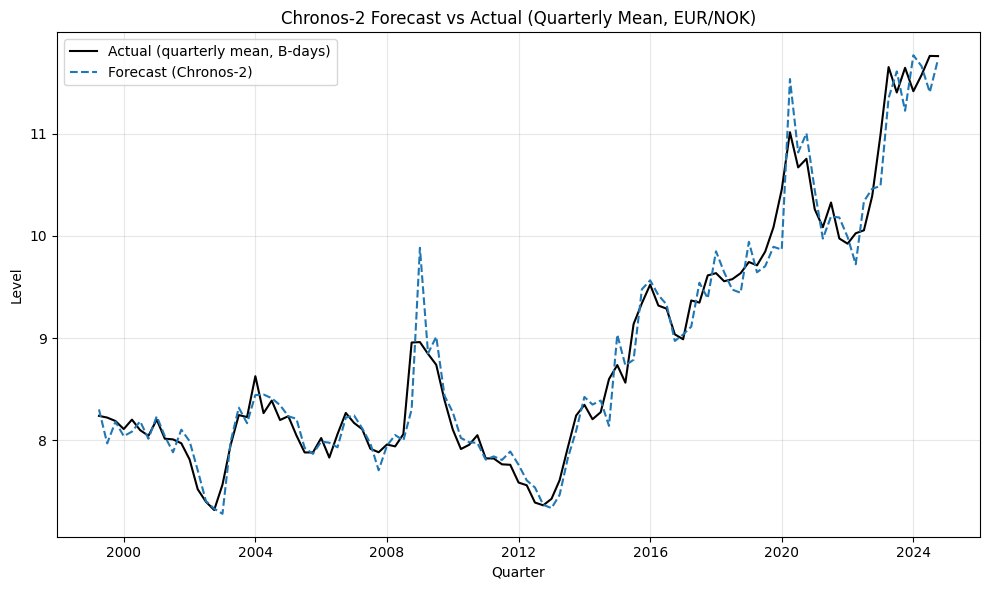

Saved: Chronos2Q.png
Saved: Chronos2Q.pdf


In [6]:
# -*- coding: utf-8 -*-
"""
Chronos-2 – EUR/NOK walk-forward (quarterly, levels), point forecast only
- Data: GitHub CSV (semicolon-separated; decimal comma), forward-filled to daily
- Cut: last business day of previous quarter
- Forecast: next calendar quarter at daily frequency -> aggregate to quarterly mean over business days
- Metrics: Observations, RMSE, MAE, Directional accuracy
- Test: Diebold–Mariano vs Random Walk (MSE, h=1)
- Plot: Actual (black) vs Forecast (blue dashed), no intervals
"""

from __future__ import annotations
import io, time, math
from dataclasses import dataclass
from typing import Optional, Tuple, Dict, List, Callable

import numpy as np
import pandas as pd
import requests, certifi
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

import torch
from chronos import BaseChronosPipeline  # from chronos-forecasting>=2.0

# -----------------------------
# Configuration
# -----------------------------
@dataclass
class Config:
    url: str = (
        "https://raw.githubusercontent.com/bredeespelid/Data_MasterOppgave/"
        "refs/heads/main/EURNOK/EUR_NOK_NorgesBank.csv"
    )
    q_freq: str = "Q-DEC"     # quarterly evaluation
    min_hist_days: int = 40
    max_context: int = 2048
    max_horizon: int = 128    # must exceed longest quarter (~92 days); 128 leaves margin
    retries: int = 3
    timeout: int = 60
    verbose: bool = True
    fig_png: str = "Chronos2Q.png"
    fig_pdf: str = "Chronos2Q.pdf"

CFG = Config()

# -----------------------------
# Download helper
# -----------------------------
def download_csv_text(url: str, retries: int, timeout: int) -> str:
    """Download CSV with simple retry/backoff."""
    last_err = None
    for k in range(1, retries + 1):
        try:
            r = requests.get(url, timeout=timeout, verify=certifi.where())
            r.raise_for_status()
            return r.text
        except Exception as e:
            last_err = e
            if k < retries:
                wait = 1.5 * k
                print(f"[warning] Download failed (try {k}/{retries}): {e}. Retrying in {wait:.1f}s ...")
                time.sleep(wait)
    raise RuntimeError(f"Download failed: {last_err}")

# -----------------------------
# Data loading
# -----------------------------
def load_series(url: str) -> Tuple[pd.Series, pd.Series]:
    """
    Load Norges Bank CSV (semicolon-separated; decimal comma) with columns TIME_PERIOD, OBS_VALUE.
    Returns:
      S_b: business-day (B) with ffill (used for cuts and quarterly ground truth)
      S_d: daily (D) with ffill (model inputs and daily forecasts)
    """
    text = download_csv_text(url, CFG.retries, CFG.timeout)
    raw = pd.read_csv(io.StringIO(text), sep=';', encoding='utf-8-sig', decimal=',')

    required_cols = {"TIME_PERIOD", "OBS_VALUE"}
    missing = required_cols - set(raw.columns)
    if missing:
        raise ValueError(f"Missing columns in CSV: {missing}. Got: {list(raw.columns)}")

    df = (raw[['TIME_PERIOD', 'OBS_VALUE']]
          .rename(columns={'OBS_VALUE': 'EUR_NOK'})
          .assign(TIME_PERIOD=lambda x: pd.to_datetime(x['TIME_PERIOD'], errors='coerce'))
          .dropna(subset=['TIME_PERIOD', 'EUR_NOK'])
          .sort_values('TIME_PERIOD')
          .set_index('TIME_PERIOD'))

    # Business-day series (truth/aggregation base)
    S_b = df['EUR_NOK'].asfreq('B').ffill().astype(float)
    S_b.name = 'EUR_NOK'

    # Daily series (model inputs / daily forecasts)
    full_idx = pd.date_range(df.index.min(), df.index.max(), freq='D')
    S_d = df['EUR_NOK'].reindex(full_idx).ffill().astype(float)
    S_d.index.name = 'DATE'
    S_d.name = 'EUR_NOK'
    return S_b, S_d

def last_trading_day(S_b: pd.Series, start: pd.Timestamp, end: pd.Timestamp) -> Optional[pd.Timestamp]:
    """Return the last business day in [start, end]."""
    sl = S_b.loc[start:end]
    return sl.index[-1] if not sl.empty else None

# -----------------------------
# Chronos-2 model builder
# -----------------------------
def build_model_chronos2(max_context: int, horizon_len: int) -> Callable[[np.ndarray, int], np.ndarray]:
    """
    Chronos-2 on CUDA + fp16; robust extraction of median forecast.
    """
    if not torch.cuda.is_available():
        raise SystemExit("CUDA not available. Install a CUDA build of PyTorch and a recent NVIDIA driver.")

    pipeline: BaseChronosPipeline = BaseChronosPipeline.from_pretrained(
        "amazon/chronos-2",
        device_map="cuda",
        torch_dtype=torch.float16,
    )

    def _extract_median(pred: pd.DataFrame) -> np.ndarray:
        # Expected schema: ["item_id","timestamp","target_name","predictions","0.1","0.5","0.9"]
        if "timestamp" in pred.columns:
            pred = pred.sort_values("timestamp")

        if "0.5" in pred.columns:
            return pred["0.5"].to_numpy()
        if "predictions" in pred.columns:
            return pred["predictions"].to_numpy()

        if "quantile" in pred.columns and "forecast" in pred.columns:
            sel = pred.loc[pred["quantile"] == 0.5, "forecast"]
            if not sel.empty:
                return sel.to_numpy()
        for cand in ("forecast", "p50", "median", "mean"):
            if cand in pred.columns:
                return pred[cand].to_numpy()

        raise RuntimeError(f"Chronos2 predict_df: unsupported schema. Columns={list(pred.columns)}.")

    def _forecast(x: np.ndarray, H: int) -> np.ndarray:
        ctx = np.asarray(x, dtype=float).ravel()[-max_context:]

        ts = pd.date_range("2000-01-01", periods=len(ctx), freq="D")
        df = pd.DataFrame({"item_id": "series_1", "timestamp": ts, "target": ctx})

        with torch.inference_mode():
            pred = pipeline.predict_df(
                df,
                prediction_length=H,
                quantile_levels=[0.5],  # median only
            )
        med = _extract_median(pred)
        return np.asarray(med, dtype=float)[:H]

    return _forecast

# -----------------------------
# Quarterly walk-forward using Chronos-2
# -----------------------------
def walk_forward_chronos2_quarterly(
    S_b: pd.Series,
    S_d: pd.Series,
    forecast_fn: Callable[[np.ndarray, int], np.ndarray]
) -> pd.DataFrame:
    """
    For each calendar quarter q:
      - cut at last business day of previous quarter
      - forecast full calendar quarter at daily frequency
      - aggregate to business-day quarterly mean and compare to truth
    """
    first_q = pd.Period(S_b.index.min(), freq=CFG.q_freq)
    last_q  = pd.Period(S_b.index.max(),  freq=CFG.q_freq)
    quarters = pd.period_range(first_q, last_q, freq=CFG.q_freq)

    rows: Dict = {}
    dropped: Dict[str, str] = {}

    for q in quarters:
        prev_q = q - 1
        q_start, q_end = q.start_time, q.end_time
        prev_start, prev_end = prev_q.start_time, prev_q.end_time

        cut = last_trading_day(S_b, prev_start, prev_end)
        if cut is None:
            dropped[str(q)] = "no_cut_in_prev_quarter"
            continue

        hist_d = S_d.loc[:cut]
        if hist_d.size < CFG.min_hist_days:
            dropped[str(q)] = f"hist<{CFG.min_hist_days}"
            continue

        # Business days inside target quarter
        idx_q_b = S_b.index[(S_b.index >= q_start) & (S_b.index <= q_end)]
        if idx_q_b.size < 1:
            dropped[str(q)] = "no_bdays_in_quarter"
            continue
        y_true = float(S_b.loc[idx_q_b].mean())

        # Horizon = full calendar quarter length (inclusive)
        H = (q_end.date() - q_start.date()).days + 1
        if H <= 0 or H > CFG.max_horizon:
            dropped[str(q)] = f"horizon_invalid(H={H})"
            continue

        # Context clipping and model forecast
        context = min(CFG.max_context, len(hist_d))
        x = hist_d.values[-context:]
        pf = forecast_fn(x, H)
        if pf.shape[0] < H:
            dropped[str(q)] = f"horizon_short({pf.shape[0]})"
            continue

        # Index daily forecast from cut+1 over H calendar days
        f_idx = pd.date_range(cut + pd.Timedelta(days=1), periods=H, freq='D')
        pred_daily = pd.Series(pf[:H], index=f_idx, name='point')

        # Aggregate forecast to business-day mean over the quarter
        pred_b = pred_daily.reindex(idx_q_b, method=None)
        if pred_b.isna().all():
            dropped[str(q)] = "no_overlap_pred_B_days"
            continue
        y_pred = float(pred_b.dropna().mean())

        rows[str(q)] = {"quarter": q, "cut": cut, "y_true": y_true, "y_pred": y_pred}

    df = pd.DataFrame.from_dict(rows, orient='index')
    if not df.empty:
        df = df.set_index("quarter").sort_index()

    if CFG.verbose and dropped:
        miss = [str(q) for q in quarters if q not in df.index]
        if miss:
            print("\nDropped quarters and reasons:")
            for qq in miss:
                print(f"  {qq}: {dropped.get(qq, 'unknown')}")
    return df

# -----------------------------
# Evaluation (level + direction)
# -----------------------------
def evaluate(eval_df: pd.DataFrame) -> pd.DataFrame:
    """Compute level errors and directional accuracy."""
    df = eval_df.copy()
    df["err"] = df["y_true"] - df["y_pred"]
    core = df.dropna(subset=["y_true", "y_pred"]).copy()

    n_obs = int(len(core))
    rmse = float(np.sqrt(np.mean(np.square(core["err"])))) if n_obs else np.nan
    mae  = float(mean_absolute_error(core["y_true"], core["y_pred"])) if n_obs else np.nan

    core["y_prev"] = core["y_true"].shift(1)
    mask = core["y_prev"].notna()
    dir_true = np.sign(core.loc[mask, "y_true"] - core.loc[mask, "y_prev"])
    dir_pred = np.sign(core.loc[mask, "y_pred"] - core.loc[mask, "y_prev"])
    hits = int((dir_true.values == dir_pred.values).sum())
    total = int(mask.sum())
    hit_rate = (hits / total) if total else np.nan

    print("\n=== Model performance (quarterly mean, EUR/NOK) ===")
    print(f"Observations: {n_obs}")
    print(f"RMSE (level): {rmse:.6f}")
    print(f"MAE  (level): {mae:.6f}")
    if total:
        print(f"Directional accuracy: {hits}/{total} ({hit_rate*100:.1f}%)")

    return core

# -----------------------------
# Diebold–Mariano (vs Random Walk)
# -----------------------------
def _normal_cdf(z: float) -> float:
    """Standard normal CDF without scipy."""
    return 0.5 * (1.0 + math.erf(z / math.sqrt(2.0)))

def dm_test(
    y_true: pd.Series,
    y_model: pd.Series,
    y_rw: pd.Series,
    h: int = 1,
    loss: str = "mse"
) -> Tuple[float, float]:
    """
    Diebold–Mariano test for equal predictive accuracy.
    Returns (DM statistic, p-value). Uses simple NW/Bartlett HAC up to lag h-1.
    """
    df = pd.concat({"y": y_true, "m": y_model, "rw": y_rw}, axis=1).dropna()
    if df.empty or len(df) < 5:
        return float("nan"), float("nan")

    e_m = df["y"] - df["m"]
    e_r = df["y"] - df["rw"]
    d = np.abs(e_m) - np.abs(e_r) if loss.lower() == "mae" else (e_m**2) - (e_r**2)

    N = int(len(d))
    d_mean = float(d.mean())
    gamma0 = float(np.var(d, ddof=1)) if N > 1 else 0.0
    var_bar = gamma0 / N

    if h > 1 and N > 2:
        for k in range(1, min(h - 1, N - 1) + 1):
            w_k = 1.0 - k / h
            cov_k = float(np.cov(d[k:], d[:-k], ddof=1)[0, 1])
            var_bar += 2.0 * w_k * cov_k / N

    if var_bar <= 0 or not np.isfinite(var_bar):
        return float("nan"), float("nan")

    dm_stat = d_mean / math.sqrt(var_bar)
    p_val = 2.0 * (1.0 - _normal_cdf(abs(dm_stat)))
    return dm_stat, p_val

def dm_against_random_walk(eval_df: pd.DataFrame, loss: str = "mse", h: int = 1) -> None:
    """Random walk benchmark = previous quarter's observed level (y_{t-1})."""
    df = eval_df.copy()
    df["rw_pred"] = df["y_true"].shift(1)
    dm_stat, p_val = dm_test(df["y_true"], df["y_pred"], df["rw_pred"], h=h, loss=loss)
    print("\n=== Diebold–Mariano vs Random Walk ===")
    print(f"Loss: {loss.upper()} | horizon h={h}")
    print(f"DM-statistic: {dm_stat:.4f}" if np.isfinite(dm_stat) else "DM-statistic: nan")
    print(f"p-value     : {p_val:.4f}" if np.isfinite(p_val) else "p-value     : nan")

# -----------------------------
# Plot (no bands)
# -----------------------------
def plot_quarterly_simple(eval_df: pd.DataFrame, png_path: str, pdf_path: str):
    """Simple line plot: actual vs forecast (quarterly mean)."""
    if eval_df.empty:
        print("Nothing to plot.")
        return

    plt.figure(figsize=(10, 6))
    x = eval_df.index.to_timestamp() if isinstance(eval_df.index, pd.PeriodIndex) else eval_df.index

    # Actual: black
    plt.plot(x, eval_df["y_true"], color="black", label="Actual (quarterly mean, B-days)")
    # Forecast: blue dashed
    plt.plot(x, eval_df["y_pred"], color="tab:blue", linestyle="--", label="Forecast (Chronos-2)")

    plt.title("Chronos-2 Forecast vs Actual (Quarterly Mean, EUR/NOK)")
    plt.xlabel("Quarter")
    plt.ylabel("Level")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

    plt.savefig(png_path, dpi=300, bbox_inches="tight")
    plt.savefig(pdf_path, bbox_inches="tight")
    plt.show()
    print(f"Saved: {png_path}")
    print(f"Saved: {pdf_path}")

# -----------------------------
# Main
# -----------------------------
def main():
    # 1) Data
    S_b, S_d = load_series(CFG.url)
    if CFG.verbose:
        print(f"Data (B): {S_b.index.min().date()} → {S_b.index.max().date()} | n={len(S_b)}")
        print(f"Data (D): {S_d.index.min().date()} → {S_d.index.max().date()} | n={len(S_d)}")

    # 2) Model (Chronos-2) and forecast wrapper
    forecast_fn = build_model_chronos2(
        max_context=CFG.max_context,
        horizon_len=min(CFG.max_horizon, 128),
    )

    # 3) Quarterly walk-forward and evaluation
    df_eval = walk_forward_chronos2_quarterly(S_b, S_d, forecast_fn)
    eval_df = evaluate(df_eval)

    # 4) Diebold–Mariano vs Random Walk (MSE; h=1)
    dm_against_random_walk(eval_df, loss="mse", h=1)

    # 5) Plot
    plot_quarterly_simple(eval_df, CFG.fig_png, CFG.fig_pdf)

if __name__ == "__main__":
    main()
